In [ ]:
#| hide
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#| default_exp models.kanhits

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# KANHITS

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional, Tuple

import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [ ]:
#| export
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [ ]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, 
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            if self.out_features>1:
                raise Exception('Cubic interpolation not available with multiple outputs.')
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size), device=knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], 
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:] # [B,None,H,H] -> [B,H]
            forecast = forecast[:,None,:] # [B,H] -> [B,None,H]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [ ]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class KANHITSBlock(nn.Module):
    """
    KANHITS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 h: int,
                 n_theta: int,
                 kan_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block KANs
        hidden_layers = [KANLinear(in_features=input_size, 
                                   out_features=kan_units[0][0])]
        for layer in kan_units:
            hidden_layers.append(KANLinear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                #raise NotImplementedError('dropout')
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [KANLinear(in_features=kan_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [ ]:
#| export
class KANHITS(BaseWindows):
    """ KANHITS

    The Kolgomorov-Arnold Neural Hierarchical Interpolation for Time Series (KANHITS), is an KAN-based (Kolgomorov-Arnold network) deep
    neural architecture with backward and forward residual links. KANHITS tackles volatility and
    memory complexity challenges, by locally specializing its sequential predictions into
    the signals frequencies with hierarchical interpolation and pooling.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `kan_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
    `n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    -[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
    Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
    Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)<br>
    -[Ziming Liu, Yixuan Wang, Sachin Vaidya, Fabian Ruehle, James Halverson, Marin Soljačić, Thomas Y. Hou, Max Tegmark. "KAN: Kolmogorov-Arnold Networks"](https://arxiv.org/abs/2404.19756)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True

    def __init__(self, 
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 kan_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(KANHITS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)

        # Architecture
        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   futr_input_size=self.futr_exog_size,
                                   hist_input_size=self.hist_exog_size,
                                   stat_input_size=self.stat_exog_size,                                   
                                   n_blocks=n_blocks,
                                   kan_units=kan_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self,
                     h, 
                     input_size,    
                     stack_types, 
                     n_blocks,
                     kan_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta, 
                     activation,
                     futr_input_size, hist_input_size, stat_input_size):                     

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + self.loss.outputsize_multiplier*max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size, forecast_size=h,
                                       out_features=self.loss.outputsize_multiplier,
                                       interpolation_mode=interpolation_mode)

                nbeats_block = KANHITSBlock(h=h,
                                          input_size=input_size,
                                          futr_input_size=futr_input_size,
                                          hist_input_size=hist_input_size,
                                          stat_input_size=stat_input_size,                                          
                                          n_theta=n_theta,
                                          kan_units=kan_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)
                
        return block_list

    def forward(self, windows_batch):
        
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        
        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))
        
        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            
            if self.decompose_forecast:
                block_forecasts.append(block_forecast)
        
        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, output_size)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

In [ ]:
show_doc(KANHITS)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/kanhits.py#L409){target="_blank" style="float:right; font-size:smaller"}

### KANHITS

>      KANHITS (h, input_size, futr_exog_list=None, hist_exog_list=None,
>               stat_exog_list=None, exclude_insample_y=False,
>               stack_types:list=['identity', 'identity', 'identity'],
>               n_blocks:list=[1, 1, 1], kan_units:list=[[512, 512], [512, 512],
>               [512, 512]], n_pool_kernel_size:list=[2, 2, 1],
>               n_freq_downsample:list=[4, 2, 1], pooling_mode:str='MaxPool1d',
>               interpolation_mode:str='linear', dropout_prob_theta=0.0,
>               activation='ReLU', loss=MAE(), valid_loss=None,
>               max_steps:int=1000, learning_rate:float=0.001,
>               num_lr_decays:int=3, early_stop_patience_steps:int=-1,
>               val_check_steps:int=100, batch_size:int=32,
>               valid_batch_size:Optional[int]=None,
>               windows_batch_size:int=1024,
>               inference_windows_batch_size:int=-1,
>               start_padding_enabled=False, step_size:int=1,
>               scaler_type:str='identity', random_seed:int=1,
>               num_workers_loader=0, drop_last_loader=False, optimizer=None,
>               optimizer_kwargs=None, lr_scheduler=None,
>               lr_scheduler_kwargs=None, **trainer_kwargs)

KANHITS

The Kolgomorov-Arnold Neural Hierarchical Interpolation for Time Series (KANHITS), is an KAN-based (Kolgomorov-Arnold network) deep
neural architecture with backward and forward residual links. KANHITS tackles volatility and
memory complexity challenges, by locally specializing its sequential predictions into
the signals frequencies with hierarchical interpolation and pooling.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
`stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
`kan_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
`n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
`n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
`dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)<br>
-[Ziming Liu, Yixuan Wang, Sachin Vaidya, Fabian Ruehle, James Halverson, Marin Soljačić, Thomas Y. Hou, Max Tegmark. "KAN: Kolmogorov-Arnold Networks"](https://arxiv.org/abs/2404.19756)

In [ ]:
show_doc(KANHITS.fit, name='KANHITS.fit')

---

### KANHITS.fit

>      KANHITS.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                   distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(KANHITS.predict, name='KANHITS.predict')

---

### KANHITS.predict

>      KANHITS.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                       **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import KANHITS
from neuralforecast.losses.pytorch import MSE
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 60.4 M
-----------------------------------------------
60.4 M    Trainable params
0         Non-trainable params
60.4 M    Total params
241.410   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/common/_base_windows.py:261: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  static = torch.repeat_interleave(
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/common/_scalers.py:30: UserWarning: The operator 'aten::nanmedian.dim_values' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  x_median, _ = x_nan.nanmedian(dim=dim, keepdim=keepdim)
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/common/_base_windows.py:558: UserWarning: MPS: no support for int64 reduction ops, casting it to int

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/utilsforecast/processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/utilsforecast/processing.py:414: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

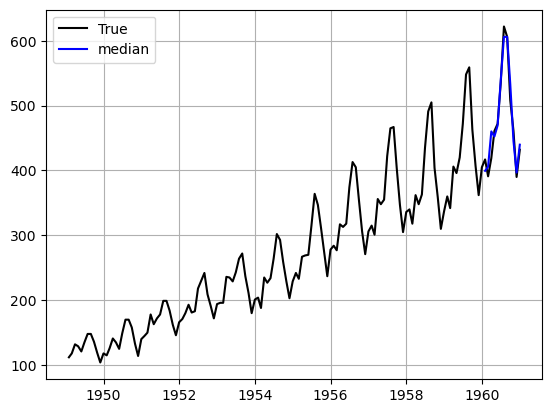

In [ ]:
#| eval: false

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = KANHITS(h=12,
              input_size=24,
              loss=MSE(),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['KANHITS'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()